<img src="images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Bankhead National Forest - RadCLss Met Tower

## Overview

The Extracted Radar Columns and In-Situ Sensors (RadClss) Value-Added Product (VAP) is
a dataset containing in-situ ground observations matched to CSAPR-2 radar columns above ARM Mobile Facility (AMF-3) supplemental sites of interest. 

Investigation into specific azimuth and range gate separation over the BNF Met Tower Site to see if RadCLss can differeniate between these close locations

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy/) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf) | Helpful | Familiarity with metadata structure |
| [GeoPandas](https://geopandas.org/en/stable/docs.html) | Necessary | Familiarity with Geospatial Plotting|
| [Py-ART / Radar Foundations](https://projectpythia.org/radar-cookbook/) | Necessary | Basics of Weather Radar | 

- **Time to learn**: 30 minutes

## In-Situ Locations
| Site  | Lat   | Lon   | Forward Azimuth | Distance |
| ----- | ----- | ----- | ----- | ----- | 
| M1    | 34.34525 | -87.33842 | 210.709 | 36.909 |
| S4    | 34.46451 | -87.23598 | 207.027 | 20.753 |
| S20   | 34.65401 | -87.29264 | 280.072 | 14.82  |
| S30   | 34.38501 | -86.92757 | 145.371 | 33.192 |
| S40   | 34.17932 | -87.45349 | 210.438 | 58.174 |
| S10.  | 34.34361 | -87.35027 | 211.995 | 37.629 |
| S13.  | 34.34388 | -87.35055 | 212.053 | 37.616 |
| S14.  | 34.34333 | -87.35083 | 212.036 | 37.682 |

In [18]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import glob
import os
import datetime
import tempfile
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
import pandas as pd
import dask
import cartopy
import cartopy.crs as ccrs

from math import atan2 as atan2
from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import OSM
from matplotlib.transforms import offset_copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axisartist.grid_finder import FixedLocator, DictFormatter
from matplotlib import colors
from dask.distributed import Client, LocalCluster
from metpy.plots import USCOUNTIES
from PIL import Image

import act
import pyart
import wradlib as wrl
import cmweather
import xradar as xd

dask.config.set({'logging.distributed': 'error'})

## Read CSAPR-2 Data with `xradar` and visualize with `wradlib`

In [ ]:
# Define the desired processing date for the BNF CSAPR-2 in YYYY-MM-DD format.
DATE = "2025-03-05"
# Define the directory where the BNF CSAPR-2 CMAC files are located.
RADAR_DIR = sorted(glob.glob(os.getenv("BNF_RADAR_R5_DIR") + "202503/*.nc"))

In [3]:
dt = xd.io.open_cfradial1_datatree(RADAR_DIR[-2])

In [4]:
dt

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 15)
│   Dimensions without coordinates: sweep
│   Data variables:
│       sweep_group_name     (sweep) <U10 600B 'sweep_0.0' ... 'sweep_14.0'
│       sweep_fixed_angle    (sweep) float32 60B ...
│       latitude             float32 4B ...
│       longitude            float32 4B ...
│       altitude             float32 4B ...
│       time_coverage_start  |S22 22B ...
│       time_coverage_end    |S22 22B ...
│       volume_number        int32 4B ...
│   Attributes:
│       Conventions:  CF/Radial instrument_parameters ARM-1.3
│       institution:  United States Department of Energy - Atmospheric Radiation ...
│       references:   See CSAPR2 Instrument Handbook
│       comment:      This is highly experimental and initial data. There are man...
│       version:      2.0 lite
│       source:       Atmospheric Radiation Measurement (ARM) program C-band Scan...
│       history:      created by user rjackson on machine cirrus47.ccs.ornl.gov a...
├── Group: /sweep_0
│       Dimensions:                                                (azimuth: 360,
│                                                                   range: 1100)
│       Coordinates:
│           time                                                   (azimuth) datetime64[ns] 3kB ...
│         * range                                                  (range) float32 4kB ...
│         * azimuth                                                (azimuth) float32 1kB ...
│           elevation                                              (azimuth) float32 1kB ...
│           latitude                                               float32 4B ...
│           longitude                                              float32 4B ...
│           altitude                                               float32 4B ...
│       Data variables: (12/62)
│           time_offset                                            (azimuth) datetime64[ns] 3kB ...
│           attenuation_corrected_differential_reflectivity        (azimuth, range) float32 2MB ...
│           attenuation_corrected_differential_reflectivity_lag_1  (azimuth, range) float32 2MB ...
│           attenuation_corrected_reflectivity_h                   (azimuth, range) float32 2MB ...
│           censor_mask                                            (azimuth, range) int32 2MB ...
│           classification_mask                                    (azimuth, range) int32 2MB ...
│           ...                                                     ...
│           rain_rate_A                                            (azimuth, range) float64 3MB ...
│           sweep_number                                           float64 8B ...
│           sweep_fixed_angle                                      float32 4B ...
│           sweep_mode                                             <U6 24B 'sector'
│           prt                                                    (azimuth) float32 1kB ...
│           nyquist_velocity                                       (azimuth) float32 1kB ...
├── Group: /sweep_1
│       Dimensions:                                                (azimuth: 361,
│                                                                   range: 1100)
│       Coordinates:
│           time                                                   (azimuth) datetime64[ns] 3kB ...
│         * range                                                  (range) float32 4kB ...
│         * azimuth                                                (azimuth) float32 1kB ...
│           elevation                                              (azimuth) float32 1kB ...
│           latitude                                               float32 4B ...
│           longitude                                              float32 4B ...
│           altitude                                               float32 4B ...
│       Data variables: (12/62)
│           time_offset                                      

In [5]:
dt['sweep_0']['corrected_reflectivity']

<xarray.DataArray 'corrected_reflectivity' (azimuth: 360, range: 1100)> Size: 3MB
[396000 values with dtype=float64]
Coordinates:
    time       (azimuth) datetime64[ns] 3kB 2025-03-05T01:50:35.091000 ... 20...
  * range      (range) float32 4kB 0.0 100.0 200.0 ... 1.098e+05 1.099e+05
  * azimuth    (azimuth) float32 1kB 0.5328 1.563 2.552 ... 357.5 358.6 359.5
    elevation  (azimuth) float32 1kB ...
    latitude   float32 4B ...
    longitude  float32 4B ...
    altitude   float32 4B ...
Attributes:
    long_name:      Corrected reflectivity
    units:          dBZ
    standard_name:  corrected_equivalent_reflectivity_factor

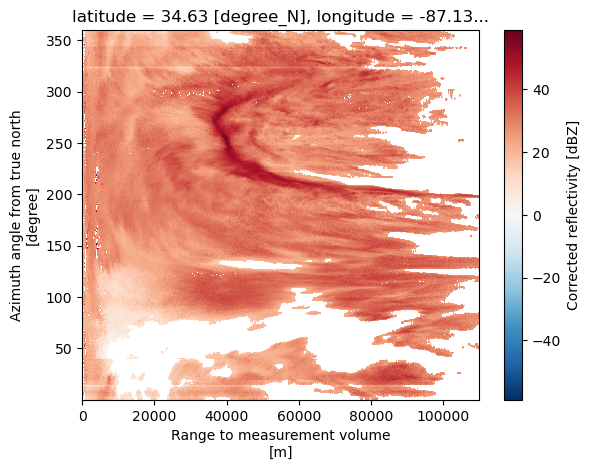

In [6]:
dt['sweep_0']['corrected_reflectivity'].plot()

### Extract the lowest sweep

In [7]:
ds = dt['sweep_0'].to_dataset()

In [8]:
ds

<xarray.Dataset> Size: 112MB
Dimensions:                                                (azimuth: 360,
                                                            range: 1100)
Coordinates:
    time                                                   (azimuth) datetime64[ns] 3kB ...
  * range                                                  (range) float32 4kB ...
  * azimuth                                                (azimuth) float32 1kB ...
    elevation                                              (azimuth) float32 1kB ...
    latitude                                               float32 4B ...
    longitude                                              float32 4B ...
    altitude                                               float32 4B ...
Data variables: (12/62)
    time_offset                                            (azimuth) datetime64[ns] 3kB ...
    attenuation_corrected_differential_reflectivity        (azimuth, range) float32 2MB ...
    attenuation_corrected_differential_reflectivity_lag_1  (azimuth, range) float32 2MB ...
    attenuation_corrected_reflectivity_h                   (azimuth, range) float32 2MB ...
    censor_mask                                            (azimuth, range) int32 2MB ...
    classification_mask                                    (azimuth, range) int32 2MB ...
    ...                                                     ...
    rain_rate_A                                            (azimuth, range) float64 3MB ...
    sweep_number                                           float64 8B ...
    sweep_fixed_angle                                      float32 4B ...
    sweep_mode                                             <U6 24B 'sector'
    prt                                                    (azimuth) float32 1kB ...
    nyquist_velocity                                       (azimuth) float32 1kB ...

### `wradlib` visualization

In [9]:
da = ds['corrected_reflectivity']

In [10]:
# note - required metadata for wradlib visualization / georeferencing
da.attrs['sweep_mode'] = 'azimuth_surveillance'

In [11]:
da = da.wrl.georef.georeference()

In [12]:
da

<xarray.DataArray 'corrected_reflectivity' (azimuth: 360, range: 1100)> Size: 3MB
[396000 values with dtype=float64]
Coordinates: (12/14)
    time       (azimuth) datetime64[ns] 3kB 2025-03-05T01:50:35.091000 ... 20...
  * range      (range) float32 4kB 0.0 100.0 200.0 ... 1.098e+05 1.099e+05
  * azimuth    (azimuth) float32 1kB 0.5328 1.563 2.552 ... 357.5 358.6 359.5
    elevation  (azimuth) float32 1kB 1.505 1.505 1.505 ... 1.505 1.505 1.505
    latitude   float32 4B 34.63
    longitude  float32 4B -87.13
    ...         ...
    y          (azimuth, range) float32 2MB 0.0 99.96 ... 1.097e+05 1.098e+05
    z          (azimuth, range) float32 2MB 12.0 14.0 ... 3.604e+03 3.609e+03
    gr         (azimuth, range) float32 2MB 0.0 99.97 ... 1.097e+05 1.098e+05
    rays       (azimuth, range) float32 2MB 0.5328 0.5328 0.5328 ... 359.5 359.5
    bins       (azimuth, range) float32 2MB 0.0 100.0 ... 1.098e+05 1.099e+05
    crs_wkt    int64 8B 0
Attributes:
    long_name:      Corrected reflectivity
    units:          dBZ
    standard_name:  corrected_equivalent_reflectivity_factor
    sweep_mode:     azimuth_surveillance

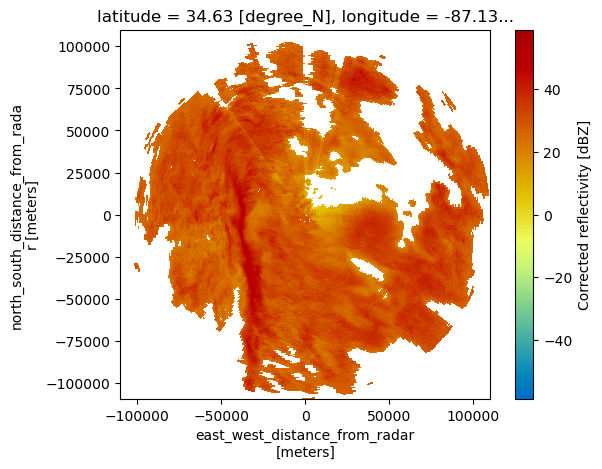

In [13]:
da.wrl.vis.plot()

## Overaly the OpenStreetMap on `wradlib` visualization

In [ ]:
# define the sites of interest
nsite = {"M1" : [34.34525, -87.33842],
         "S4" : [34.46451, -87.23598],
         "S3" : [34.63080, -87.13311],
         "S20" : [34.65401, -87.29264],
         "S30" : [34.38501, -86.92757],
         "S40" : [34.17932, -87.45349],
         "S10" : [34.34361, -87.35027],
         "S13" : [34.34388, -87.35055],
         "S14" : [34.34333, -87.35083]}

# define the center of the map to be the CSAPR2
central_lon = -87.13076
central_lat = 34.63080

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


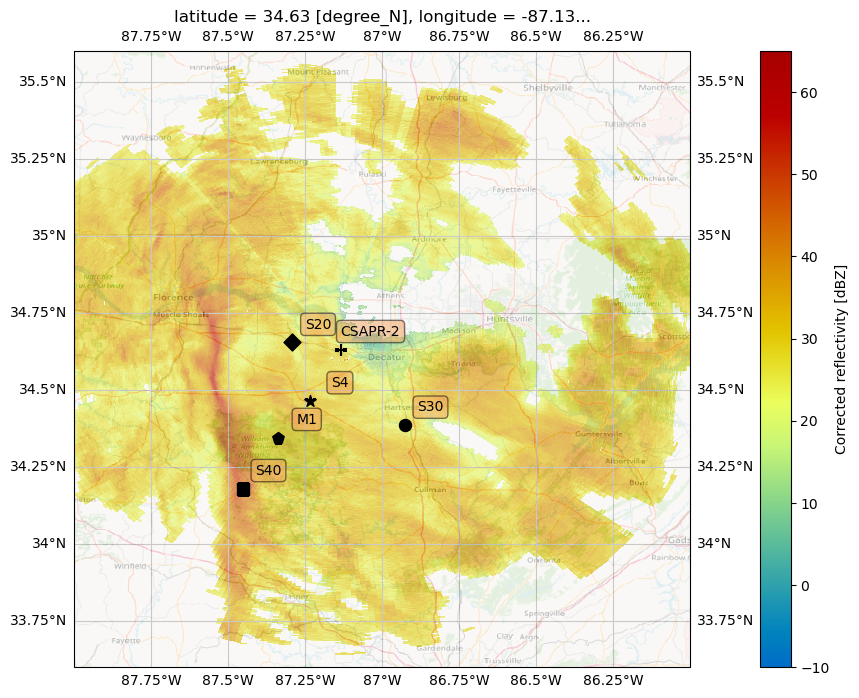

In [ ]:
fig = plt.figure(figsize=(18, 8))
tiler = OSM()
mercator = tiler.crs

ax = fig.add_subplot(111, 
                     projection=ccrs.PlateCarree())

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.COASTLINE)
ax.add_image(tiler, 9, zorder=2, alpha=0.4)
# Set the BNF Domain (adjust later for various groups)
ax.set_extent([272.0, 274.0, 35.1, 34.1])
gl = ax.gridlines(draw_labels=True)
# Hide the right side ticks
ax.tick_params(labeltop=False, labelright=False)

# Add the column sites
markers = ["p", "*", "+", "D", "o", "s"]
for i, site in enumerate(nsite):
        ax.scatter(nsite[site][1],
                   nsite[site][0],
                   marker=markers[i],
                   color="black",
                   s=75,
                   label=site,
                   zorder=3,
                   transform=ccrs.PlateCarree())
        
        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        # note - taken from cartopy examples
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        if site == "S3":
            # Add text upper right of the site marker.
            ax.text(nsite[site][1]+0.03, 
                    nsite[site][0]+0.01, 
                    "CSAPR-2", 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))
        else:
            # Add text upper right of the site marker.
            ax.text(nsite[site][1]-0.035, 
                    nsite[site][0]+0.01, 
                    site, 
                    verticalalignment='center', 
                    horizontalalignment='right', 
                    transform=text_transform,
                    bbox=dict(facecolor='sandybrown', 
                    alpha=0.5, 
                    boxstyle='round'))

cg = {"radial_spacing": 10.0, "latmin": 34}
da.wrl.vis.plot(ax=ax,
                vmin=-10,
                vmax=65)

## Sector Curvelinear Grid - PPI - Bankhead National Forest

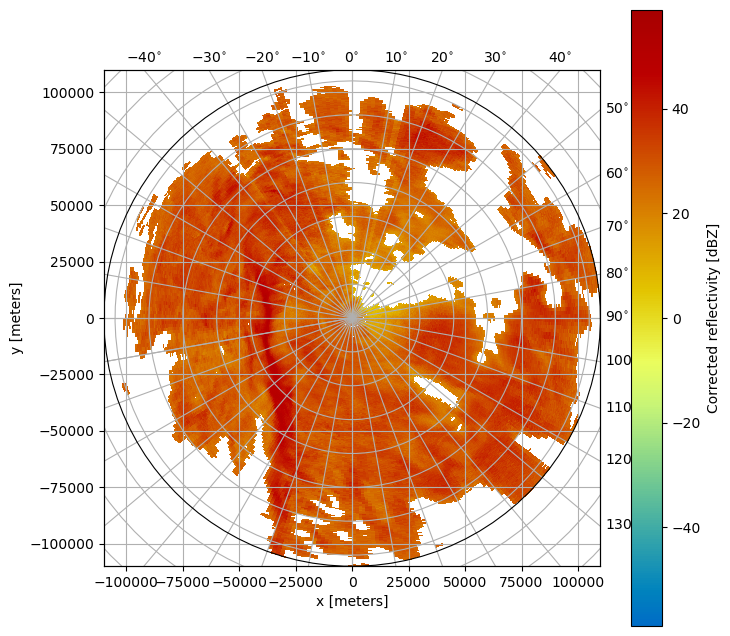

In [16]:
# very basic curvelinear graph
fig = plt.figure(figsize=(8, 8))
pm = da.wrl.vis.plot(fig=fig, crs='cg')

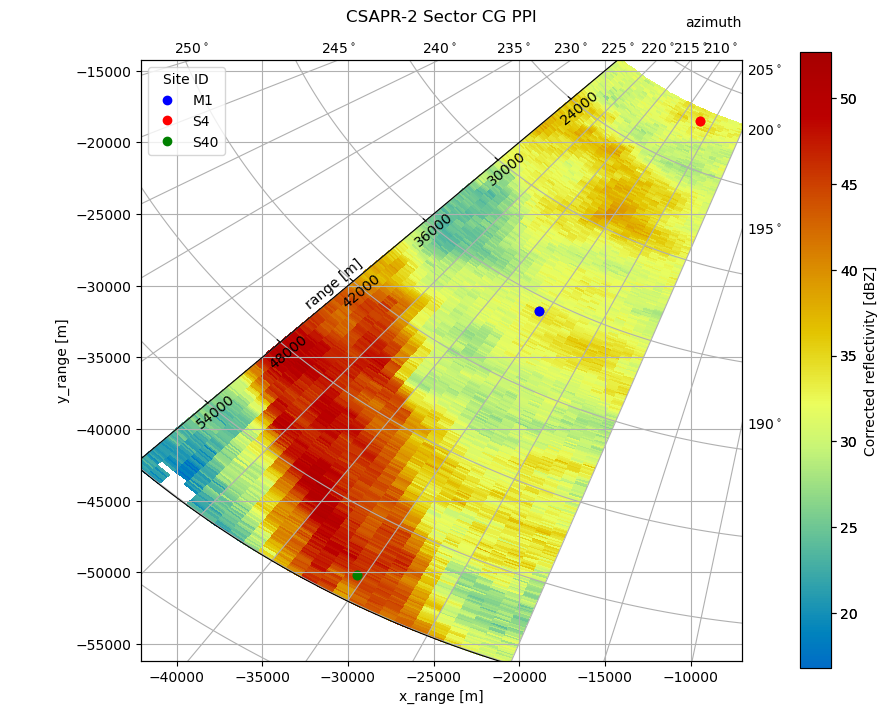

In [ ]:
cg = {"angular_spacing": 5.0}
fig = plt.figure(figsize=(10, 8))
sel = da.sel(azimuth=slice(200, 225), range=slice(20000, 60000))
pm = sel.wrl.vis.plot(
    fig=fig,
    crs=cg,
    infer_intervals=True,
)
cgax = plt.gca() # main axis
caax = cgax.parasites[0] # cartesian axis
paax = cgax.parasites[1] # polar axis

t = plt.title("CSAPR-2 Sector CG PPI", y=1.05)
cbar = plt.gcf().colorbar(pm, pad=0.075, ax=cgax)
caax.set_xlabel("x_range [m]")
caax.set_ylabel("y_range [m]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")

# set azimuth resolution to 5deg and display
gh = cgax.get_grid_helper()
locs = [i for i in np.arange(0.0, 360.0, 5)]
gh.grid_finder.grid_locator1 = FixedLocator(locs)
gh.grid_finder.tick_formatter1 = DictFormatter(
    dict([(i, r"${0:.0f}^\circ$".format(i)) for i in locs])
)
# Define the number of range ticks
gh.grid_finder.grid_locator2._nbins = 10
#gh.grid_finder.grid_locator2._steps = [1, 1.5, 2, 2.5, 5, 10]
cgax.axis["lat"] = cgax.new_floating_axis(0, 225)
cgax.axis["lat"].set_ticklabel_direction("-")
cgax.axis["lat"].label.set_text("range [m]")
cgax.axis["lat"].label.set_rotation(180)
cgax.axis["lat"].label.set_pad(10)

# Plot sites on the polar Axis
paax.plot(210.709, 36909, "bo", label="M1", zorder=1)
paax.plot(207.027, 20753, "ro", label="S4", zorder=1)
paax.plot(210.438, 58174, "go", label="S40", zorder=1)

handles, labels = cgax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
cgax.legend(by_label.values(),
            by_label.keys(),
            loc="upper left",    # whatever placement you want
            title="Site ID")

## CV Grid over BNF Tall Tower Site

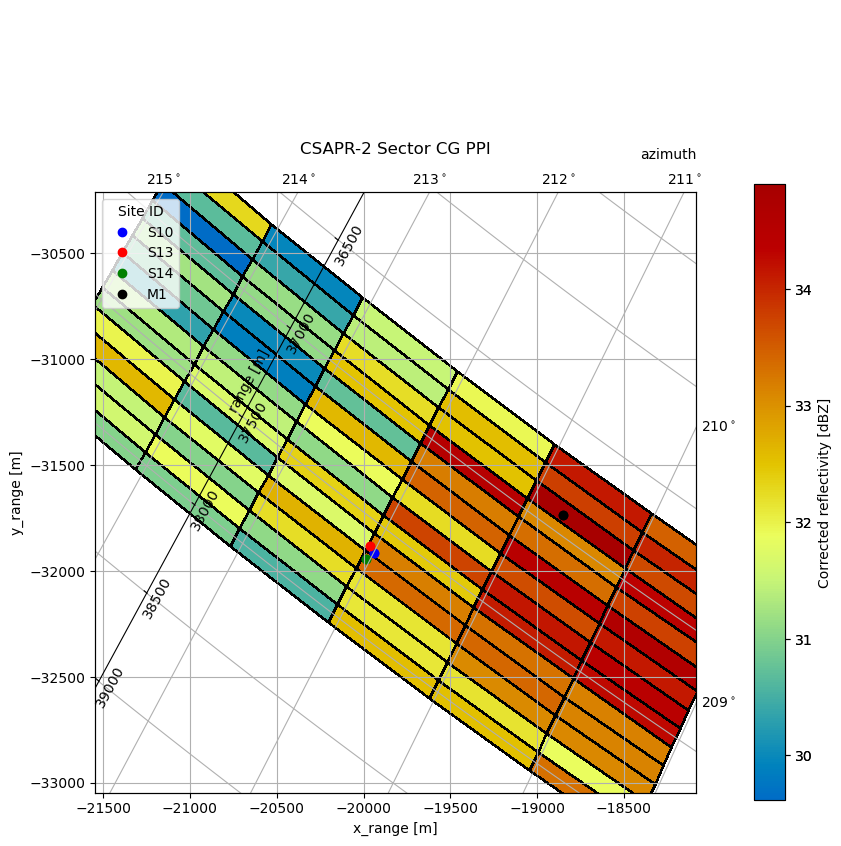

In [46]:
cg = {"angular_spacing": 5.0}
fig = plt.figure(figsize=(10, 8))
sel = da.sel(azimuth=slice(209, 215), range=slice(36680, 38000))
pm = sel.wrl.vis.plot(
    fig=fig,
    crs=cg,
    infer_intervals=True,
    edgecolors='black'
)
cgax = plt.gca() # main axis
caax = cgax.parasites[0] # cartesian axis
paax = cgax.parasites[1] # polar axis

t = plt.title("CSAPR-2 Sector CG PPI", y=1.05)
cbar = plt.gcf().colorbar(pm, pad=0.075, ax=cgax)
caax.set_xlabel("x_range [m]")
caax.set_ylabel("y_range [m]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")

# set azimuth resolution to 5deg and display
gh = cgax.get_grid_helper()
locs = [i for i in np.arange(0.0, 360.0, 1)]
gh.grid_finder.grid_locator1 = FixedLocator(locs)
gh.grid_finder.tick_formatter1 = DictFormatter(
    dict([(i, r"${0:.0f}^\circ$".format(i)) for i in locs])
)
# Define the number of range ticks
gh.grid_finder.grid_locator2._nbins = 10
#gh.grid_finder.grid_locator2._steps = [1, 1.5, 2, 2.5, 5, 10]
cgax.axis["lat"] = cgax.new_floating_axis(0, 213.5)
cgax.axis["lat"].set_ticklabel_direction("-")
cgax.axis["lat"].label.set_text("range [m]")
cgax.axis["lat"].label.set_rotation(180)
cgax.axis["lat"].label.set_pad(10)

# Plot sites on the polar Axis
paax.plot(211.995, 37629, "bo", label="S10", zorder=1)
paax.plot(212.053, 37616, "ro", label="S13", zorder=1)
paax.plot(212.036, 37682, "go", label="S14", zorder=1)
paax.plot(210.709, 36909, "ko", label="M1", zorder=1)

handles, labels = cgax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
cgax.legend(by_label.values(),
            by_label.keys(),
            loc="upper left",    # whatever placement you want
            title="Site ID")